# Case Ifood
## Raphael Reis Coelho
## Vaga: Data Analyst

### O Problema:
O departamento de marketing do Ifood é responsável criar campanhas e ofertá-las aos seus clientes. Ao todo já foram feitas 5 campanhas anteriores e agora, uma campanha piloto está em desenvolvimento para que o time da Data Science seja capaz de dizer mais claramente, quais clientes irão ou não participar da campanha. Espera-se que após esse teste, a campanha de número 6 seja mais acertiva e com uma taxa de sucesso maior.

Para este teste piloto foram escolhidos 2240 clientes aleatoriamente que foram contactados para que os mesmos adquirissem a Campanha. Os clientes então foram rotulados e agora tenta-se entender os perfis dos consumidores que aderem as campanhas.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split

A base da campanha piloto contém 2240 linhas e 29 colunas. Temos algumas informações sócio-demográficas dos clientes como o ano de nascimento, se possuem crianças/adolescentes em casa, estado cívil e etc. e algumas informações firmográficas como o quanto eles gastam em determinados produtos, por onde fazem suas compras e se já participaram das campanhas anteriores.

In [2]:
#df = pd.read_excel("C:\\Users\\raphael.coelho\\PythonP\\ifood\\Case.xlsx")
df = pd.read_excel("C:\\Users\\rapha\\PythonP\\Cases\\ifood\\Case.xlsx")

df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
print(len(df))

2240


In [4]:
print(df.isnull().sum())

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64


Antes da análise exploratória, algumas etapas de pré-processamento foram efetuadas:

- Substituição dos Valores NaN da coluna "income" pela média de valores da própria coluna;
- Acréscimo de coluna de tempo como cliente;
- Acréscimo de coluna de aceitação:
    - Há 5 colunas referente as campanhas anteriores. O intuito é entender o perfil de todos que aceitaram a campanha em algum momento. Logo, fez-se uma coluna onde é checado se o cliente em questão já participou de alguma campanha, seja a primeira ou a ultima, ou se ele nunca participou de nenhuma.
- Acréscimo de coluna de filhos:
    - É importante determinar se o cliente que tem filhos, seja criança ou adolescente, aceita mais campanhas do que os que não possuem filhos.
- Acréscimo de coluna de idade;
- Acréscimo de coluna de total gasto com produtos;
- Substituição dos valores da coluna de 'Complain.'

In [5]:
df['Income'] = df['Income'].fillna(round(df['Income'].mean(),0))

In [6]:

curr_time = pd.to_datetime("now")

df['Time_as_customer'] = curr_time - df['Dt_Customer']
df['Time_as_customer'] = df['Time_as_customer'].astype(str)
df['Time_as_customer'] = df.Time_as_customer.str[:4]
df['Time_as_customer'] = df['Time_as_customer'].astype(int)

In [7]:
df.loc[(df['AcceptedCmp1'] == 1) | (df['AcceptedCmp2'] ==1) | (df['AcceptedCmp3'] ==1) | (df['AcceptedCmp4'] ==1) | (df['AcceptedCmp5'] ==1), 'Accepted'] = 'Applied before'
df['Accepted'].fillna('Never Applied', inplace=True)

In [8]:
df.loc[(df['Kidhome'] >= 1) | (df['Teenhome'] >=1), 'Have_Children'] = 'Yes'
df['Have_Children'].fillna('No', inplace=True)

In [9]:
df['Age'] = 2020 - df['Year_Birth']

In [10]:
df['MntTotal'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

In [11]:
df['Complain'] = df['Complain'].map( {0: 'No Complaint', 
                                      1: 'Complained', }).astype(str)

Fez-se então um describe na base para entender a distribuição dos dados numéricos. Com base nos quartis, foram definidas faixas para algumas variáveis. Foram elas:
- Age
- Income
- MntWines
- MntFruits
- MntMeatProducts
- MntFishProducts
- MntSweetProducts
- MntGoldtProducts
- NumDealsPurchases
- NumWebPurchases
- NumCatalogPurchases
- NumStorePurchases
- NumWebVisitsMonth
- MntTotal

In [12]:
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Z_CostContact,Z_Revenue,Response,Time_as_customer,Age,MntTotal
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,1968.805804,52247.248661,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,0.074554,0.072768,0.064286,0.013393,3.0,11.0,0.149107,2582.582143,51.194196,605.798214
std,3246.662198,11.984069,25037.797168,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,0.262728,0.259813,0.245316,0.114976,0.0,0.0,0.356274,202.122512,11.984069,602.249288
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,2229.000000,24.000000,5.000000
25%,2828.250000,1959.000000,35538.750000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,2409.750000,43.000000,68.750000
50%,5458.500000,1970.000000,51741.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,2584.500000,50.000000,396.000000
75%,8427.750000,1977.000000,68289.750000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,2758.000000,61.000000,1045.500000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000,2928.000000,127.000000,2525.000000


In [13]:
#df['Age'] = df['Age'].astype('int')
df['Age_bins'] = df['Age']
df.loc[ df['Age'] <= 29, 'Age_bins'] = '<30'
df.loc[(df['Age'] >= 30) & (df['Age'] <= 39), 'Age_bins'] = '30-39'
df.loc[(df['Age'] >= 40) & (df['Age'] <= 49), 'Age_bins'] = '40-49'
df.loc[(df['Age'] >= 50) & (df['Age'] <= 59), 'Age_bins'] = '50-59'
df.loc[(df['Age'] >= 60) & (df['Age'] <= 69), 'Age_bins'] = '60-69'
df.loc[(df['Age'] >= 70) ,'Age_bins'] = '>70'

df['Income_bins'] = df['Income']
df.loc[ df['Income'] < 35000, 'income_bins'] = '<35k'
df.loc[(df['Income'] >= 35000) & (df['Income'] < 50000), 'income_bins'] = '35k-49k'
df.loc[(df['Income'] >= 50000) & (df['Income'] <= 70000), 'income_bins'] = '50k-70k'
df.loc[(df['Income'] > 70000) ,'income_bins'] = '>70k'

df['Recency_bins'] = df['Recency']
df.loc[ df['Recency'] < 25, 'Recency_bins'] = '<25 days'
df.loc[(df['Recency'] >= 25) & (df['Recency'] < 50), 'Recency_bins'] = '25-49 days'
df.loc[(df['Recency'] >= 50) & (df['Recency'] <= 75), 'Recency_bins'] = '50-75 days'
df.loc[(df['Recency'] > 75) ,'Recency_bins'] = '>75 days'

df['MntWines_bins'] = df['MntWines']
df.loc[ df['MntWines'] < 25, 'MntWines_bins'] = '<25'
df.loc[(df['MntWines'] >= 25) & (df['MntWines'] < 175), 'MntWines_bins'] = '25-174'
df.loc[(df['MntWines'] >= 175) & (df['MntWines'] <= 500), 'MntWines_bins'] = '175-500'
df.loc[(df['MntWines'] > 500) ,'MntWines_bins'] = '>500'

df['MntFruits_bins'] = df['MntFruits']
df.loc[ df['MntFruits'] < 2, 'MntFruits_bins'] = '<2'
df.loc[(df['MntFruits'] >= 2) & (df['MntFruits'] < 8), 'MntFruits_bins'] = '2-7'
df.loc[(df['MntFruits'] >= 8) & (df['MntFruits'] <= 35), 'MntFruits_bins'] = '8-35'
df.loc[(df['MntFruits'] > 35) ,'MntFruits_bins'] = '>35'

df['MntMeatProducts_bins'] = df['MntMeatProducts']
df.loc[ df['MntMeatProducts'] < 17, 'MntMeatProducts_bins'] = '<17'
df.loc[(df['MntMeatProducts'] >= 17) & (df['MntMeatProducts'] < 67), 'MntMeatProducts_bins'] = '17-66'
df.loc[(df['MntMeatProducts'] >= 67) & (df['MntMeatProducts'] <= 232), 'MntMeatProducts_bins'] = '67-232'
df.loc[(df['MntMeatProducts'] > 232) ,'MntMeatProducts_bins'] = '>232'

df['MntFishProducts_bins'] = df['MntFishProducts']
df.loc[ df['MntFishProducts'] < 4, 'MntFishProducts_bins'] = '<4'
df.loc[(df['MntFishProducts'] >= 4) & (df['MntFishProducts'] < 12), 'MntFishProducts_bins'] = '4-11'
df.loc[(df['MntFishProducts'] >= 12) & (df['MntFishProducts'] <= 50), 'MntFishProducts_bins'] = '12-50'
df.loc[(df['MntFishProducts'] > 50) ,'MntFishProducts_bins'] = '>50'

df['MntSweetProducts_bins'] = df['MntSweetProducts']
df.loc[ df['MntSweetProducts'] < 2, 'MntSweetProducts_bins'] = '<2'
df.loc[(df['MntSweetProducts'] >= 2) & (df['MntSweetProducts'] < 8), 'MntSweetProducts_bins'] = '2-7'
df.loc[(df['MntSweetProducts'] >= 8) & (df['MntSweetProducts'] <= 35), 'MntSweetProducts_bins'] = '8-35'
df.loc[(df['MntSweetProducts'] > 35) ,'MntSweetProducts_bins'] = '>35'

df['MntGoldProds_bins'] = df['MntGoldProds']
df.loc[ df['MntGoldProds'] < 10, 'MntGoldProds_bins'] = '<10'
df.loc[(df['MntGoldProds'] >= 10) & (df['MntGoldProds'] < 25), 'MntGoldProds_bins'] = '10-24'
df.loc[(df['MntGoldProds'] >= 25) & (df['MntGoldProds'] <= 55), 'MntGoldProds_bins'] = '25-55'
df.loc[(df['MntGoldProds'] > 55) ,'MntGoldProds_bins'] = '>55'

df['NumDealsPurchases_bins'] = df['NumDealsPurchases']
df.loc[ df['NumDealsPurchases'] < 2, 'NumDealsPurchases_bins'] = '<2'
df.loc[(df['NumDealsPurchases'] >= 2) & (df['NumDealsPurchases'] <= 3), 'NumDealsPurchases_bins'] = '2-3'
df.loc[(df['NumDealsPurchases'] > 3) ,'NumDealsPurchases_bins'] = '>3'

df['NumWebPurchases_bins'] = df['NumWebPurchases']
df.loc[ df['NumWebPurchases'] < 3, 'NumWebPurchases_bins'] = '<3'
df.loc[(df['NumWebPurchases'] >= 3) & (df['NumWebPurchases'] <= 6), 'NumWebPurchases_bins'] = '3-6'
df.loc[(df['NumWebPurchases'] > 6) ,'NumWebPurchases_bins'] = '>6'

df['NumCatalogPurchases_bins'] = df['NumCatalogPurchases']
df.loc[ df['NumCatalogPurchases'] < 2, 'NumCatalogPurchases_bins'] = '<2'
df.loc[(df['NumCatalogPurchases'] >= 2) & (df['NumCatalogPurchases'] <= 4), 'NumCatalogPurchases_bins'] = '2-4'
df.loc[(df['NumCatalogPurchases'] > 4) ,'NumCatalogPurchases_bins'] = '>4'

df['NumStorePurchases_bins'] = df['NumStorePurchases']
df.loc[ df['NumStorePurchases'] < 4, 'NumStorePurchases_bins'] = '<4'
df.loc[(df['NumStorePurchases'] >= 4) & (df['NumStorePurchases'] <= 6), 'NumStorePurchases_bins'] = '4-6'
df.loc[(df['NumStorePurchases'] >= 6) & (df['NumStorePurchases'] <= 8), 'NumStorePurchases_bins'] = '6-8'
df.loc[(df['NumStorePurchases'] > 8) ,'NumStorePurchases_bins'] = '>8'

df['NumWebVisitsMonth_bins'] = df['NumWebVisitsMonth']
df.loc[ df['NumWebVisitsMonth'] < 4, 'NumWebVisitsMonth_bins'] = '<4'
df.loc[(df['NumWebVisitsMonth'] >= 4) & (df['NumWebVisitsMonth'] <= 6), 'NumWebVisitsMonth_bins'] = '4-6'
df.loc[(df['NumWebVisitsMonth'] > 6) ,'NumWebVisitsMonth_bins'] = '>6'

df['MntTotal_bins'] = df['MntTotal']
df.loc[ df['MntTotal'] < 6, 'MntTotal_bins'] = '<6'
df.loc[(df['MntTotal'] >= 6) & (df['MntTotal'] <= 65), 'MntTotal_bins'] = '6-65'
df.loc[(df['MntTotal'] >= 65) & (df['MntTotal'] <= 400), 'MntTotal_bins'] = '65-400'
df.loc[(df['MntTotal'] > 400) ,'MntTotal_bins'] = '>400'

In [14]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntMeatProducts_bins,MntFishProducts_bins,MntSweetProducts_bins,MntGoldProds_bins,NumDealsPurchases_bins,NumWebPurchases_bins,NumCatalogPurchases_bins,NumStorePurchases_bins,NumWebVisitsMonth_bins,MntTotal_bins
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,>232,>50,>35,>55,2-3,>6,>4,4-6,>6,>400
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,<17,<4,<2,<10,2-3,<3,<2,<4,4-6,6-65
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,67-232,>50,8-35,25-55,<2,>6,2-4,>8,4-6,>400
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,17-66,4-11,2-7,<10,2-3,<3,<2,4-6,4-6,6-65
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,67-232,12-50,8-35,10-24,>3,3-6,2-4,6-8,4-6,>400


Na análise exploratória, primeiramente foi traçado um histograma das idades. E logo pode-se perceber que grande parte dos clientes está na faixa dos 40 aos 60 anos.

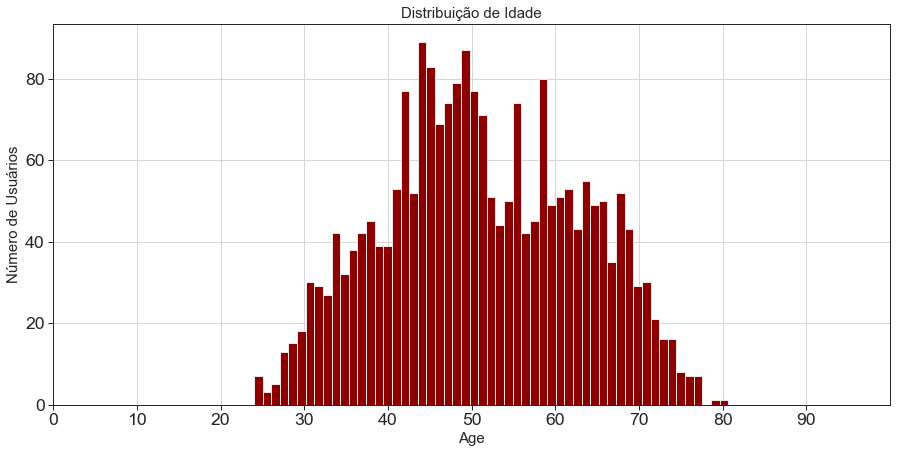

In [344]:
# Gerando um histograma
plt.figure(figsize=(15,7))
df.Age.hist(bins = 100, color = "darkred")
axes = plt.gca()
axes.set_xlim([0,100])
plt.xticks(np.arange(100, step=10))
plt.xlabel("Age", fontsize = 15)
plt.ylabel("Número de Usuários", fontsize = 15)
plt.title("Distribuição de Idade", fontsize = 15)
plt.show()

Do universo total de clientes, tem-se um sub-universo de 463 clientes que já aceitaram alguma campanha. Foi traçado então o  perfil dos clientes deste sub-universo.

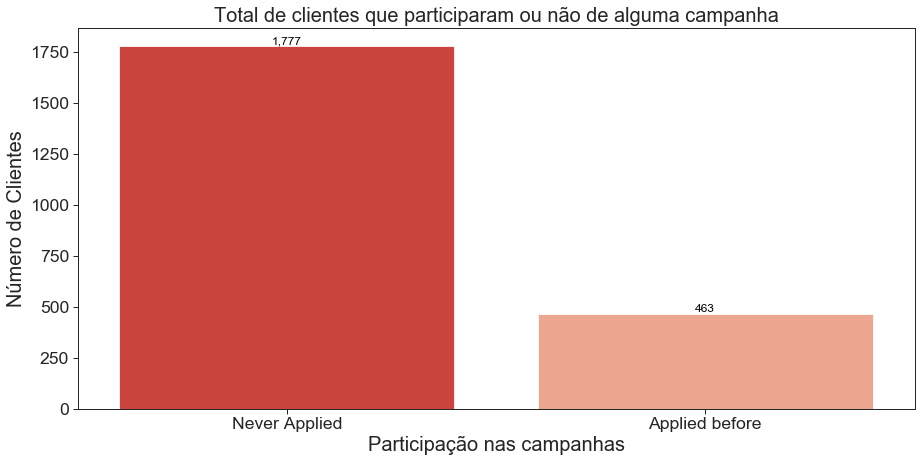

In [34]:
plt.figure(figsize=(15,7))
sns.set_context("paper", font_scale=2, rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20, "legend.title_fontsize":20}) 
sns.set_style('ticks')
sns.countplot(x='Accepted',
              palette = "Reds_r",
              data=df)
ax = plt.gca()
for p in ax.patches:
    labels = ax.text(p.get_x() + p.get_width()/2, np.nan_to_num(p.get_height(),0), "{:0,.0f}".format(np.nan_to_num(p.get_height(),0)) ,
            fontsize=12, color='black', ha='center', va='bottom')
plt.xlabel("Participação nas campanhas")
plt.ylabel('Número de Clientes')
plt.title("Total de clientes que participaram ou não de alguma campanha")
plt.show()

In [35]:
def make_countplot(x,hue,order,hue_order,xlabel,title,l_title):
    
    plt.figure(figsize=(15,7))
    sns.set_context("paper", font_scale=2, rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20, "legend.title_fontsize":20}) 
    sns.set_style('ticks')
    sns.countplot(x=x,
                  hue=hue,
                  palette = "Reds_r",
                  order=order,
                  hue_order=hue_order,
                  data=df)
    ax = plt.gca()
    for p in ax.patches:
        labels = ax.text(p.get_x() + p.get_width()/2, np.nan_to_num(p.get_height(),0), "{:0,.0f}".format(np.nan_to_num(p.get_height(),0)) ,
                fontsize=12, color='black', ha='center', va='bottom')
    plt.legend(loc='upper right',title=l_title, title_fontsize=17)
    plt.xlabel(xlabel)
    plt.ylabel('Número de Clientes')
    plt.title(title)
    plt.show()

Ao avaliar a faixa etária, observa-se uma certa normalidade nos dados de quem já aceitou alguma campanha. Quase 50% dos clientes ficam nas faixas de 40-49 (24,6%) e 50-59 (24,4%), o que indica que nessas faixas há maior aceitação. É importante destacar que estas faixas são as que detem o maior número de clientes. Logo, é necessário levar mais dados em conta.

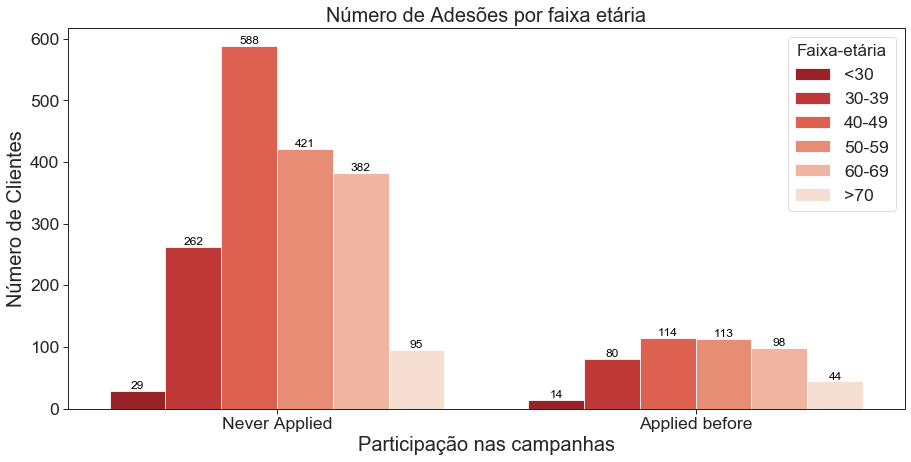

In [36]:
make_countplot(
    x = 'Accepted',
    hue = 'Age_bins',
    order = ['Never Applied', 'Applied before'],
    hue_order = ['<30','30-39','40-49','50-59','60-69','>70'],
    xlabel = 'Participação nas campanhas',
    title = 'Número de Adesões por faixa etária',
    l_title = 'Faixa-etária'
)


Nesta análise vê-se que os clientes com maiores rendas aceitam mais as campanhas, na qual a faixa de >70k compreende 49,5% dos clientes do sub-universo. Este achado nos indica uma proporcionalidade direta: quanto mais alta a renda, maior número de clientes que aderem à campanha.

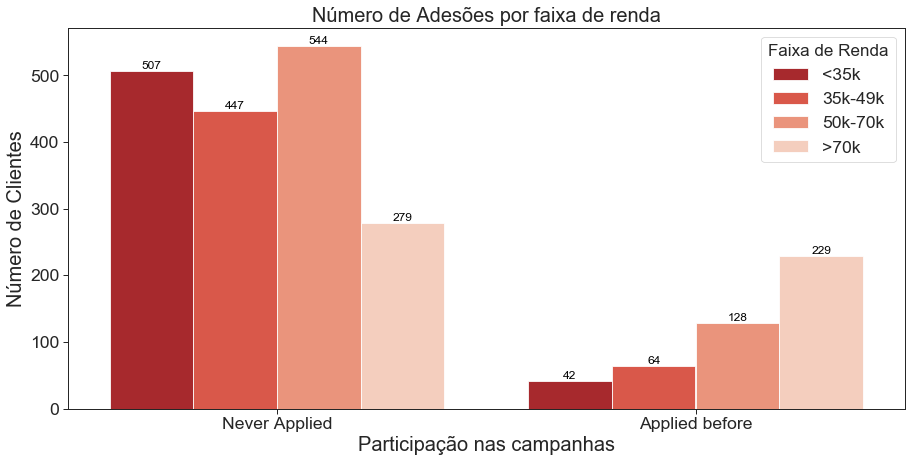

In [37]:
make_countplot(
    x = 'Accepted',
    hue = 'income_bins',
    order = ['Never Applied', 'Applied before'],
    hue_order = ['<35k','35k-49k','50k-70k','>70k'],
    xlabel = 'Participação nas campanhas',
    title = 'Número de Adesões por faixa de renda',
    l_title = 'Faixa de Renda'
)

Nesta análise vemos que os clientes com maiores gastos com vinhos aceitam mais as campanhas, na qual a faixa de >500 de montante gasto compreende 59,4% dos clientes do sub-universo. Este achado indica uma proporcionalidade direta: quanto mais alto o valor gasto com vinhos, maior número de clientes aderidos a campanha.

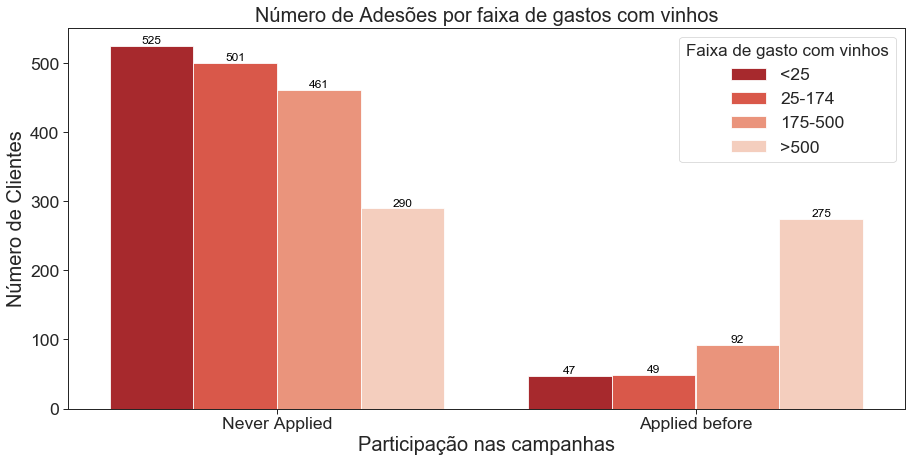

In [38]:
make_countplot(
    x = 'Accepted',
    hue = 'MntWines_bins',
    order = ['Never Applied', 'Applied before'],
    hue_order = ['<25','25-174','175-500','>500'],
    xlabel = 'Participação nas campanhas',
    title = 'Número de Adesões por faixa de gastos com vinhos',
    l_title = 'Faixa de gasto com vinhos'
)

Nesta análise vê-se que os clientes com  gastos com frutas entre 8-35 e >35 aceitam mais as campanhas. Estas faixas compreendem 35,2% e 31.7% dos clientes do sub-universo.

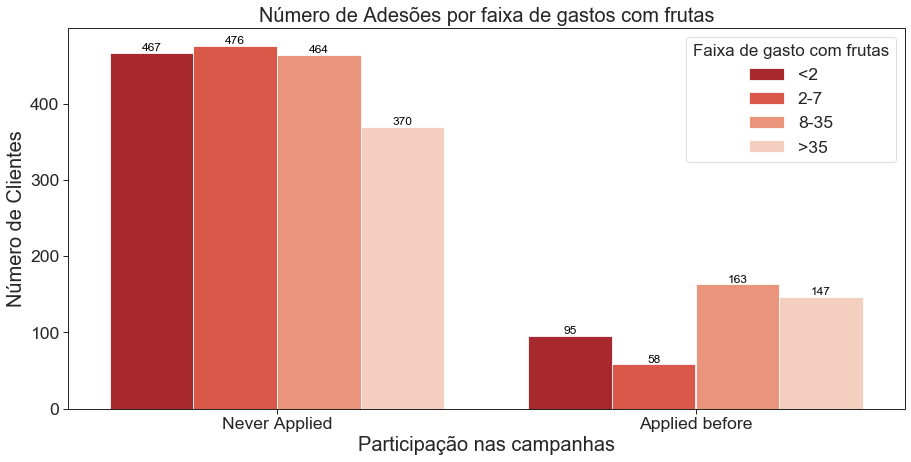

In [39]:
make_countplot(
    x = 'Accepted',
    hue = 'MntFruits_bins',
    order = ['Never Applied', 'Applied before'],
    hue_order = ['<2','2-7','8-35','>35'],
    xlabel = 'Participação nas campanhas',
    title = 'Número de Adesões por faixa de gastos com frutas',
    l_title = 'Faixa de gasto com frutas'
)

Nesta análise vê-se que os clientes com maiores gastos com carnes aceitam mais as campanhas, na qual a faixa de >232 compreende 45,8% dos clientes do sub-universo. Este achado indica uma proporcionalidade direta: quanto mais alto valor gasto, maior número de clientes aderidos a campanha.

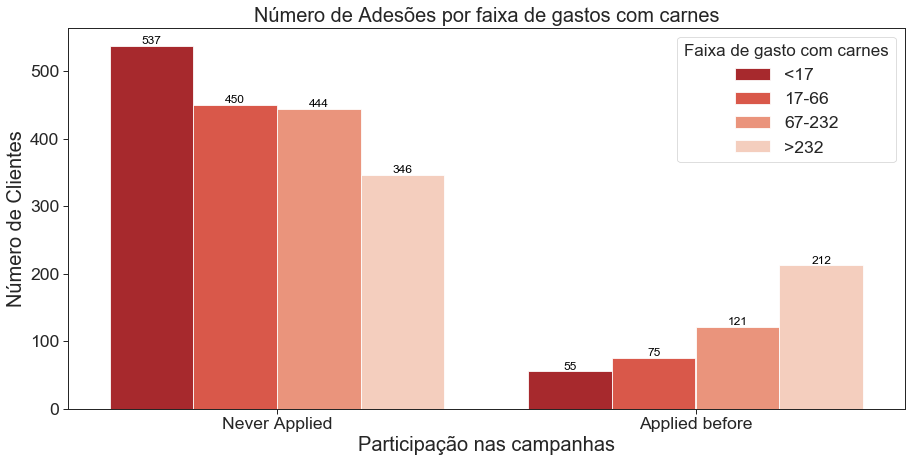

In [40]:
make_countplot(
    x = 'Accepted',
    hue = 'MntMeatProducts_bins',
    order = ['Never Applied', 'Applied before'],
    hue_order = ['<17','17-66','67-232', '>232'],
    xlabel = 'Participação nas campanhas',
    title = 'Número de Adesões por faixa de gastos com carnes',
    l_title = 'Faixa de gasto com carnes'
    
)

Nesta análise vê-se uma distribuição um pouco mais linear para os gastos com peixes, na qual apenas faixa de >4-11 está mais abaixo das demais, compreendendo apenas 11,2% dos clientes do sub-universo. A última faixa é a predominante, com 37,8% dos clientes.

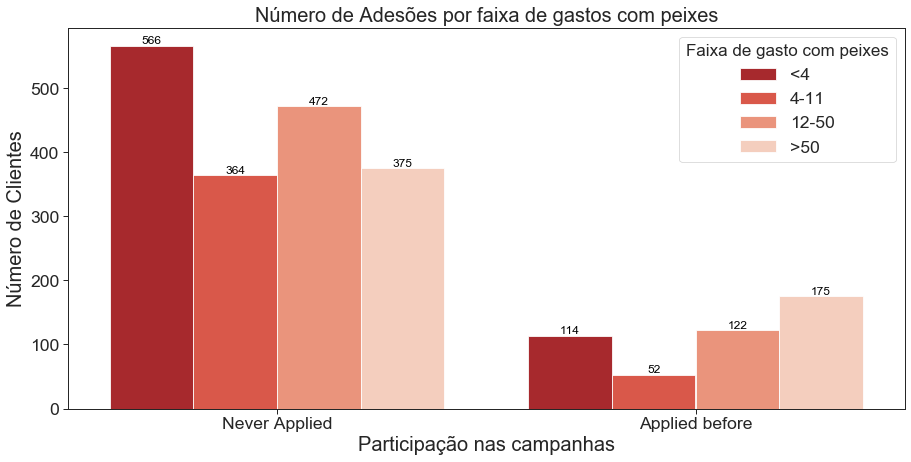

In [41]:
make_countplot(
    x = 'Accepted',
    hue = 'MntFishProducts_bins',
    order = ['Never Applied', 'Applied before'],
    hue_order = ['<4','4-11','12-50', '>50'],
    xlabel = 'Participação nas campanhas',
    title = 'Número de Adesões por faixa de gastos com peixes',
    l_title = 'Faixa de gasto com peixes'
)

Nesta análise vê-se uma distribuição um pouco mais linear para os gastos com doces, na qual apenas faixa de >2-7 está mais abaixo das demais compreendendo apenas 11,2% dos clientes do sub-universo. A última faixa é a predominante, com 35,9% dos clientes.

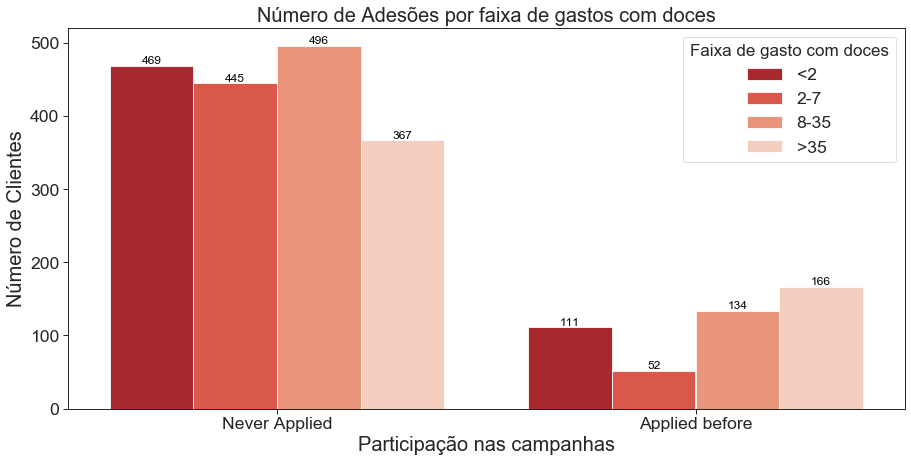

In [42]:
make_countplot(
    x = 'Accepted',
    hue = 'MntSweetProducts_bins',
    order = ['Never Applied', 'Applied before'],
    hue_order = ['<2','2-7','8-35','>35'],
    xlabel = 'Participação nas campanhas',
    title = 'Número de Adesões por faixa de gastos com doces',
    l_title = 'Faixa de gasto com doces'
)

Nesta análise vê-se que os clientes com maiores gastos com produtos premium aceitam mais as campanhas, na qual a faixa de >55 compreende 38.9% dos clientes do sub-universo. Este achado indica uma proporcionalidade direta: quanto mais alto valor gasto, maior número de clientes aderidos a campanha.

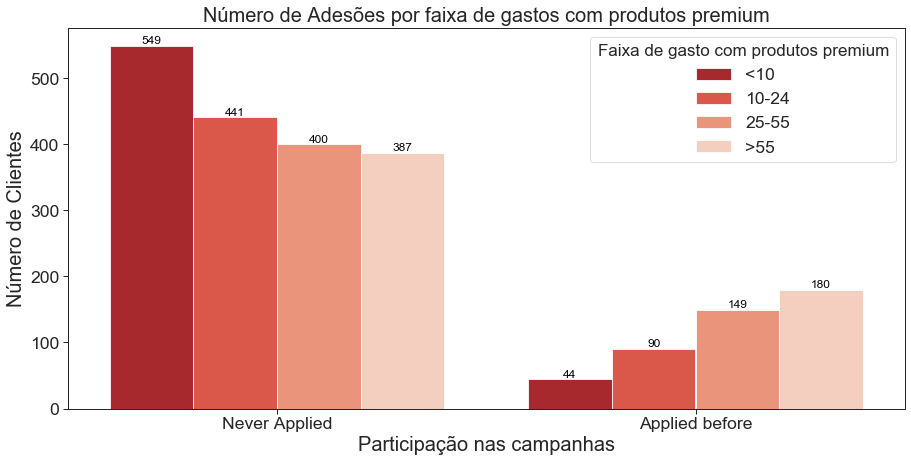

In [43]:
make_countplot(
    x = 'Accepted',
    hue = 'MntGoldProds_bins',
    order = ['Never Applied', 'Applied before'],
    hue_order = ['<10','10-24','25-55','>55'],
    xlabel = 'Participação nas campanhas',
    title = 'Número de Adesões por faixa de gastos com produtos premium',
    l_title = 'Faixa de gasto com produtos premium'
)

Compilando todos estes gastos, podemos inferir que os clientes com gastos gerais acima de 400, aderem muito mais as campanhas. Esta faixa corresponde a 79,7% dos clientes. Logo, é mais válido identificar o valor gasto total e por de meio deste indicador oferecer as campanhas aos clientes que mais gastam.

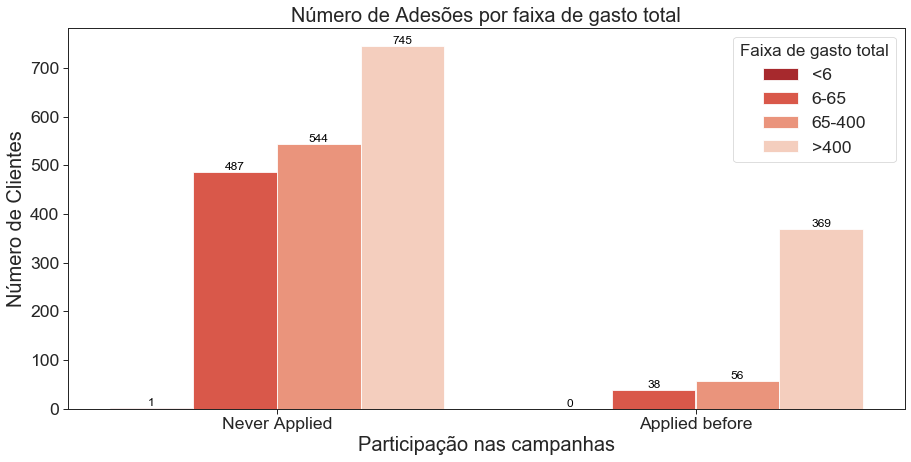

In [44]:
make_countplot(
    x = 'Accepted',
    hue = 'MntTotal_bins',
    order = ['Never Applied', 'Applied before'],
    hue_order = ['<6','6-65','65-400','>400'],
    xlabel = 'Participação nas campanhas',
    title = 'Número de Adesões por faixa de gasto total',
    l_title = 'Faixa de gasto total'
)

Nesta análise observa-se que os clientes que fazem menos compras com descontos aceitam mais as campanhas. A faixa de <2 compreende 58.7% dos clientes do sub-universo. Este achado indica uma proporcionalidade inversa: quanto maior o número de compras, menor o número de clientes aderidos a campanha.

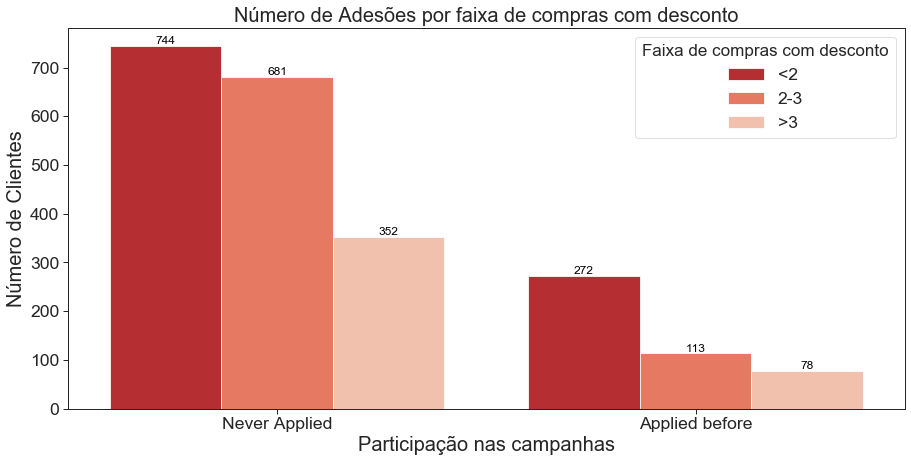

In [45]:
make_countplot(
    x = 'Accepted',
    hue = 'NumDealsPurchases_bins',
    order = ['Never Applied', 'Applied before'],
    hue_order = ['<2','2-3','>3'],
    xlabel = 'Participação nas campanhas',
    title = 'Número de Adesões por faixa de compras com desconto',
    l_title = 'Faixa de compras com desconto'
)

Nesta análise osbserva-se que os clientes que fazem de 3 a 6 compras pelo website aceitam mais as campanhas. Esta faixa compreende 53.3% dos clientes do sub-universo.

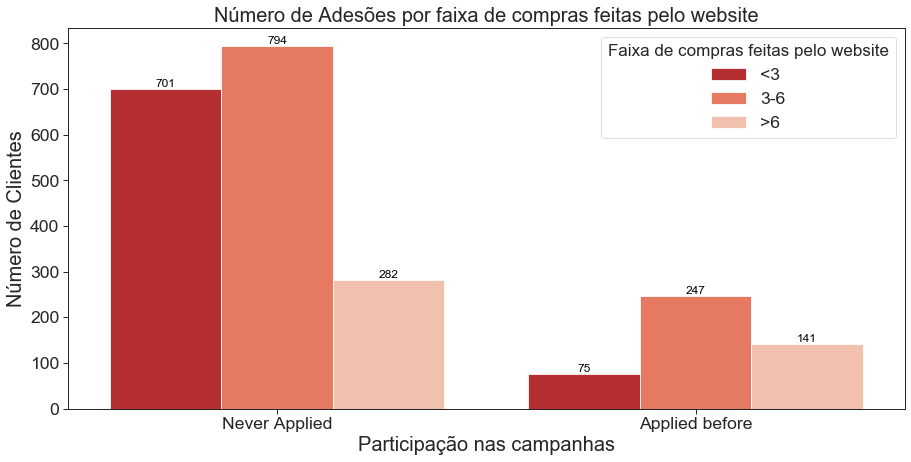

In [46]:
make_countplot(
    x = 'Accepted',
    hue = 'NumWebPurchases_bins',
    order = ['Never Applied', 'Applied before'],
    hue_order = ['<3','3-6','>6'],
    xlabel = 'Participação nas campanhas',
    title = 'Número de Adesões por faixa de compras feitas pelo website',
    l_title = 'Faixa de compras feitas pelo website'
)

Nesta análise observa-se que os clientes que fazem mais compras com catálogos aceitam mais as campanha. A faixa de >4 compreende 46.6% dos clientes do sub-universo. Este achado indica uma proporcionalidade direta: quanto maior o número de compras, maior o número de clientes aderidos a campanha.

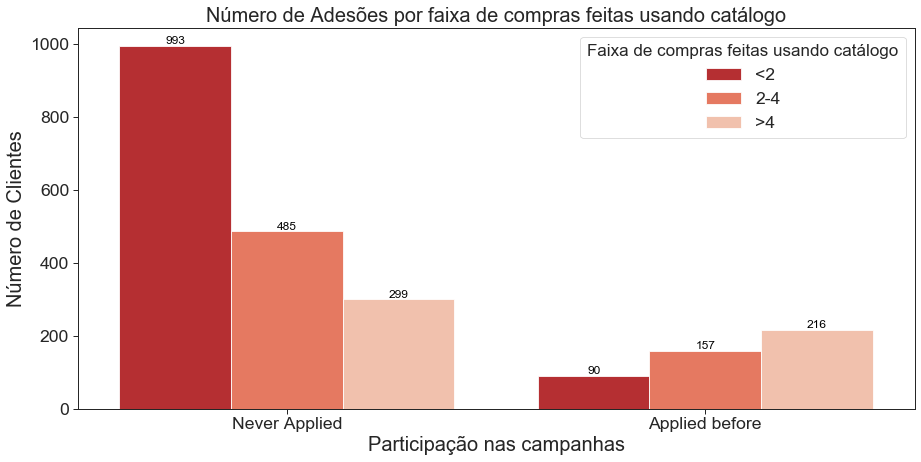

In [47]:
make_countplot(
    x = 'Accepted',
    hue = 'NumCatalogPurchases_bins',
    order = ['Never Applied', 'Applied before'],
    hue_order=['<2','2-4','>4'],
    xlabel = 'Participação nas campanhas',
    title = 'Número de Adesões por faixa de compras feitas usando catálogo',
    l_title = 'Faixa de compras feitas usando catálogo'
)

Nesta análise observa-se que os clientes que fazem mais compras diretamente na loja aceitam mais as campanhas. As faixas de 6-8 e >8 compreendem 30.4% e 33.9% dos clientes do sub-universo. Este achado indica uma proporcionalidade direta: quanto mais o número de compras, maior o número de clientes aderidos a campanha.

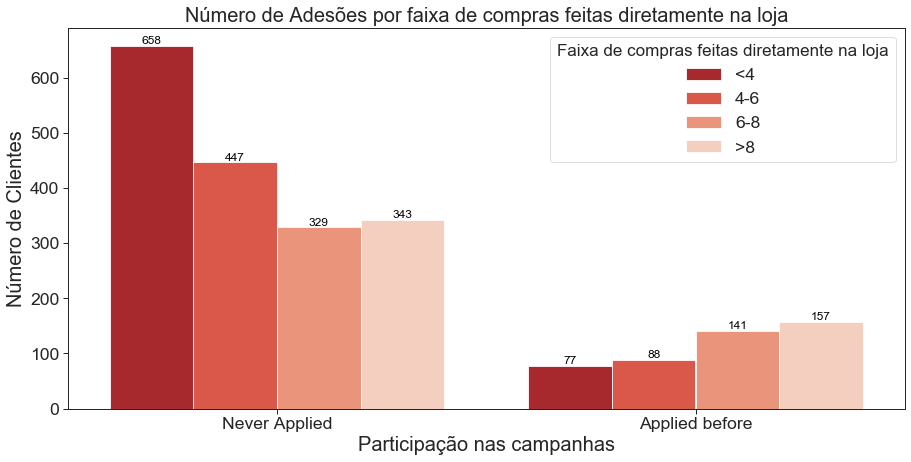

In [48]:
make_countplot(
    x = 'Accepted',
    hue = 'NumStorePurchases_bins',
    order = ['Never Applied', 'Applied before'],
    hue_order = ['<4','4-6','6-8','>8'],
    xlabel = 'Participação nas campanhas',
    title = 'Número de Adesões por faixa de compras feitas diretamente na loja',
    l_title = 'Faixa de compras feitas diretamente na loja'
)

Nesta análise vemos que os clientes que visitam menos o website aceitam mais as campanhas, embora o número de clientes seja relativamente linear em todas as faixas. A faixa de <4 compreende 37,8% dos clientes do sub-universo. Este achado indica uma sutil proporcionalidade inversa: quanto maior o número de visitas, menor o número de clientes aderidos a campanha.

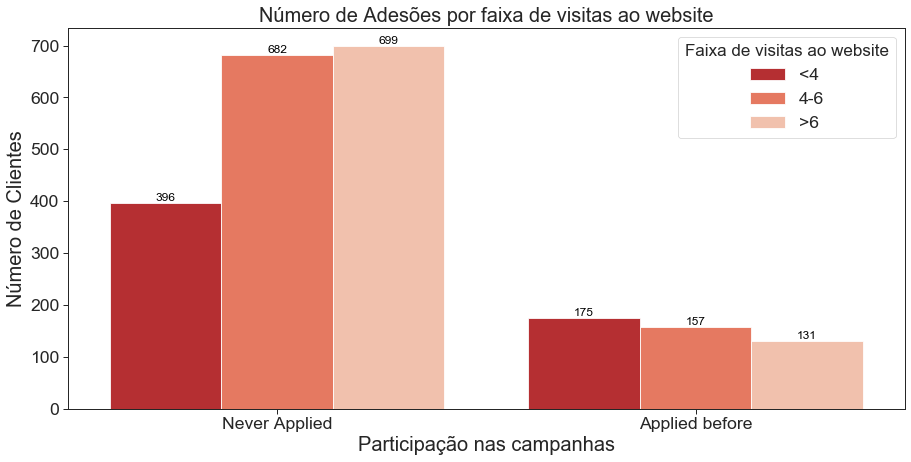

In [49]:
make_countplot(
    x = 'Accepted',
    hue = 'NumWebVisitsMonth_bins',
    order = ['Never Applied', 'Applied before'],
    hue_order = ['<4','4-6','>6'],
    xlabel = 'Participação nas campanhas',
    title = 'Número de Adesões por faixa de visitas ao website',
    l_title = 'Faixa de visitas ao website'
)

Olhando agora para as informações sócio-demográficas dos clientes, poderia-se inferir em um primeiro momento que os clientes que não tem crianças e/ou adolescentes em casa aderem mais a campanha. Todavia, como esta informação foi compilada em uma nova variável, foi feita uma análise mais direcionada procurando identificar se ter filhos impacta mais hora de aderir às campanhas ou não.

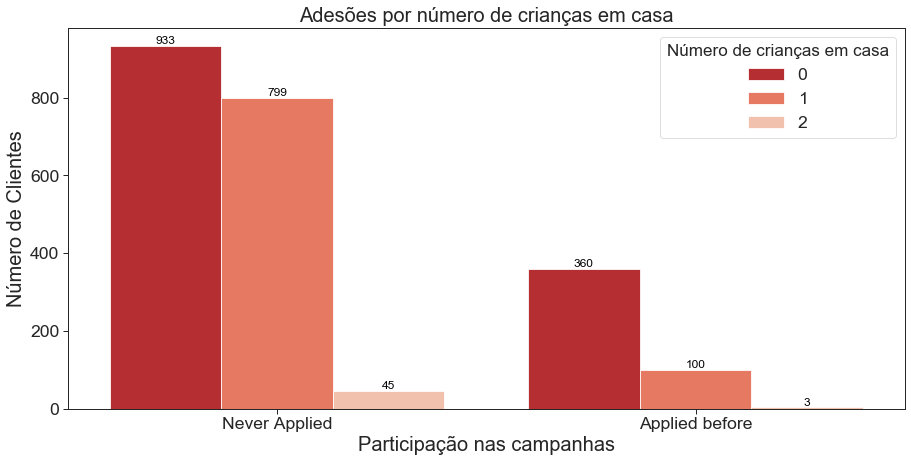

In [50]:
make_countplot(
    x = 'Accepted',
    hue = 'Kidhome',
    order = ['Never Applied', 'Applied before'],
    hue_order = [0,1,2],
    xlabel = 'Participação nas campanhas',
    title = 'Adesões por número de crianças em casa',
    l_title = 'Número de crianças em casa'
)

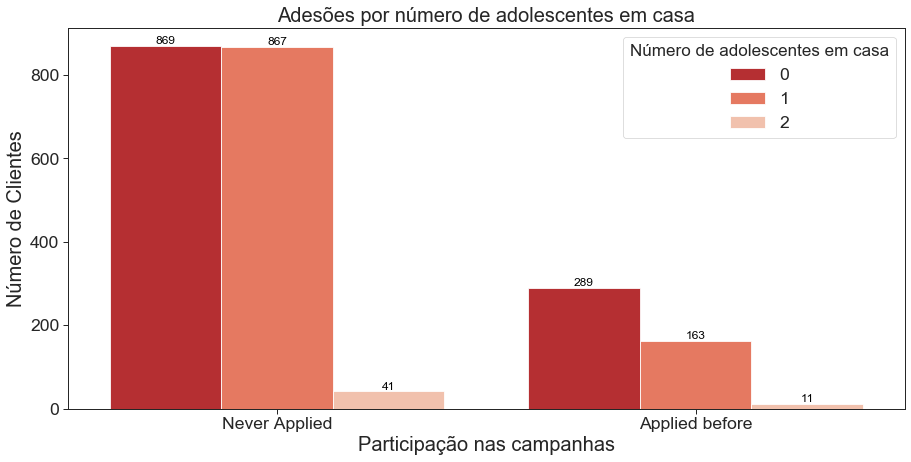

In [51]:
make_countplot(
    x = 'Accepted',
    hue = 'Teenhome',
    order = ['Never Applied', 'Applied before'],
    hue_order = [0,1,2],
    xlabel = 'Participação nas campanhas',
    title = 'Adesões por número de adolescentes em casa',
    l_title = 'Número de adolescentes em casa'
)

Logo observa-se que o quesito ter filhos não é determinante para dizer se o cliente irá ou não aceitar a campanha.

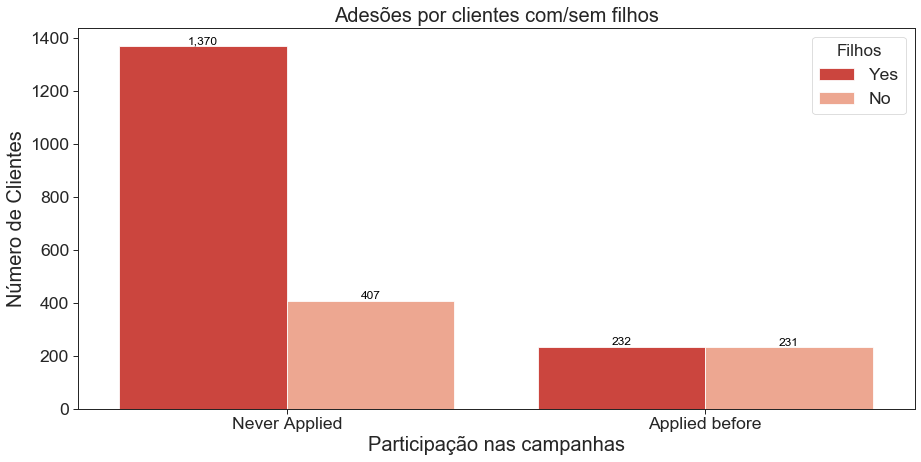

In [52]:
make_countplot(
    x = 'Accepted',
    hue = 'Have_Children',
    order = ['Never Applied', 'Applied before'],
    hue_order = ["Yes","No"],
    xlabel = 'Participação nas campanhas',
    title = 'Adesões por clientes com/sem filhos',
    l_title = 'Filhos'
)

Olhando o estado cívil, vemos que os clientes que são solteiros, tem algum tipo de união ou são casados aderem mais as campanhas. Destes 3 grupos, os casados aderem mais, sendo cerca de 39,3% dos clientes.

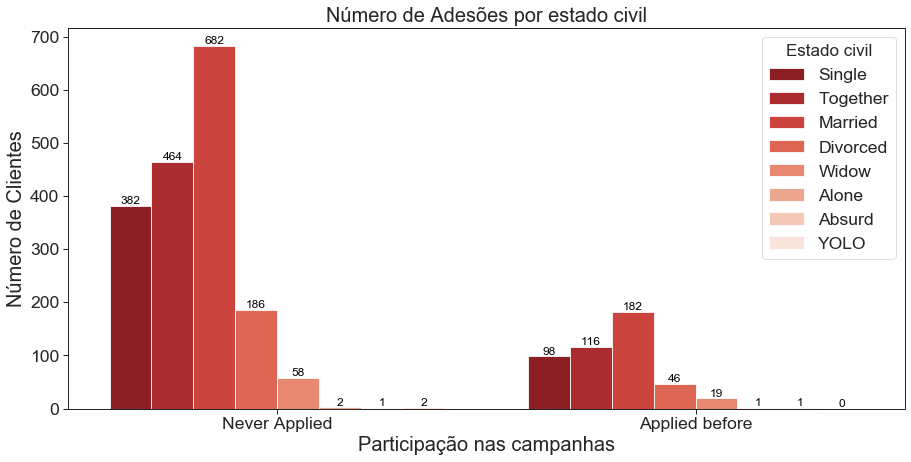

In [53]:
make_countplot(
    x = 'Accepted',
    hue = 'Marital_Status',
    order = ['Never Applied', 'Applied before'],
    hue_order = ['Single','Together','Married','Divorced','Widow','Alone','Absurd','YOLO'],
    xlabel = 'Participação nas campanhas',
    title = 'Número de Adesões por estado civil',
    l_title = 'Estado civil'
)

Olhando o grau de escolaridade, observa-se que os clientes graduados e com PhD aderem mais as campanhas, sendo estes correspondentes a 49,7% e 24,6% dos clientes, respectivamente.

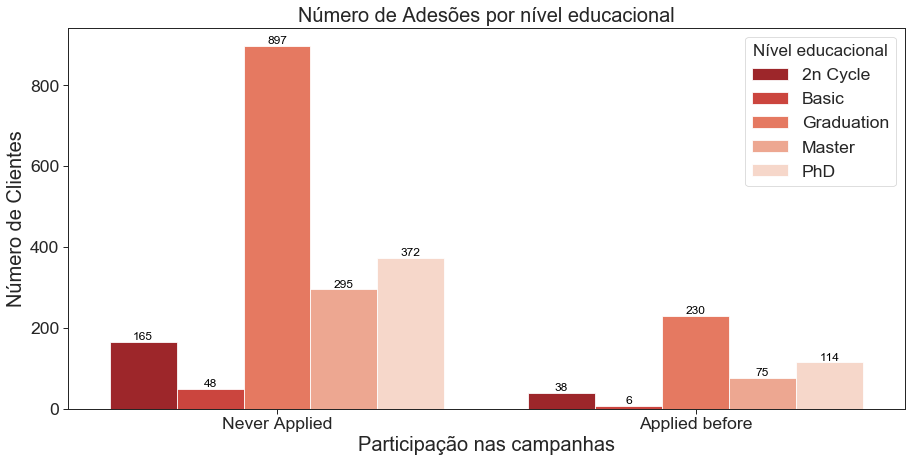

In [54]:
make_countplot(
    x = 'Accepted',
    hue = 'Education',
    order = ['Never Applied', 'Applied before'],
    hue_order = ['2n Cycle','Basic','Graduation','Master','PhD'],
    xlabel = 'Participação nas campanhas',
    title = 'Número de Adesões por nível educacional',
    l_title = 'Nível educacional'
)

Por último, analisaram-se as reclamações, apesar do número de clientes ser pequeno. Destes, apenas 2 aceitaram campanhas, o equivalente a 9% deste universo de 21 clientes. Logo, pode-se inferir que os clientes não fizeram reclamações no passado tem mais probabilidade de aceitar futuras campanhas.

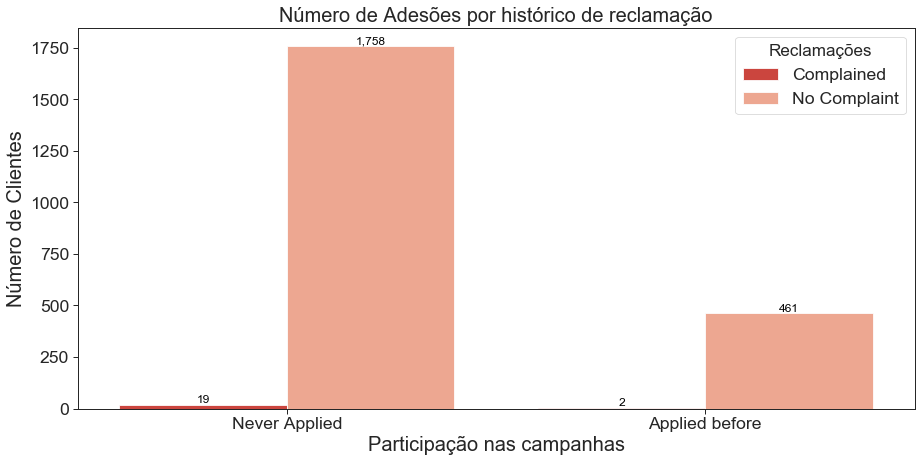

In [56]:
make_countplot(
    x = 'Accepted',
    hue = 'Complain',
    order = ['Never Applied', 'Applied before'],
    hue_order = ['Complained','No Complaint'],
    xlabel = 'Participação nas campanhas',
    title = 'Número de Adesões por histórico de reclamação',
    l_title = 'Reclamações'
)

Para a modelagem, primeiramente traçou-se a matriz de correlação para identificar se havia alguma variável com correlação alta, seja positiva ou negativa levando em consideração a variável alvo (Response). Todavia, não houve nenhum destaque significativo.

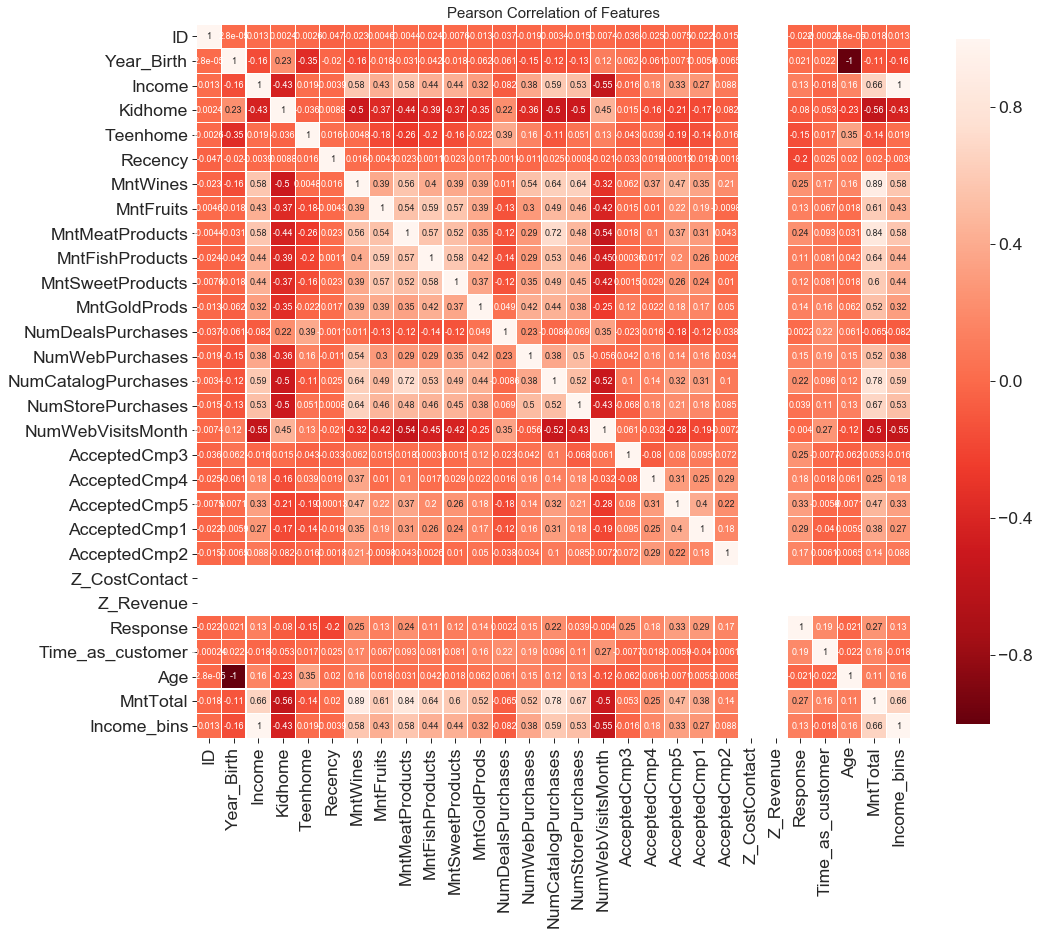

In [42]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(16, 14))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = 'Reds_r',
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':9 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(df)


Duas abordagens foram traçadas:
- Não dividir o dataset entre treino e teste
- Dividir o dataset entre treino e teste

Em ambos os casos foram executados sucessíveis testes mesclando números de variáveis diferentes, com parametros específicos de cada modelo.

Não bastava simplesmente o modelo ter uma acurácia alta, pois os clientes que não aceitam campanhas são predominantes na base. Se fosse dado atenção apenas para essa métrica, bastava assumir que nenhum cliente iria aceitar a campanha que a taxa de acurácia já seria alta. Todavia, este não era o objetivo. Logo, buscou-se um modelo que conseguisse dizer com maior precisão quem não iria aceitar a campanha e quem iria.

Em ambos os casos, o modelo que teve uma melhor resposta foi o de redes neurais: 
- Não dividindo: foi previsto corretamente 221 casos de aceite da campanha, o equivalente a 66.7% com uma taxa de acurácia global de 84,51%.
- dividindo: foi previsto corretamente 157 casos de aceite da campanha, o equivalente a 56.47% com uma taxa de acurácia global de 85,24%.

Cada modelo, bem como as suas métricas podem ser vistas abaixo. Posteriormente é possível ver 3 gráficos pra cada caso (não dividindo/dividindo), nos quais é mostrado a acurácia de todos os modelos, bem como as taxas de acerto dos clientes que aderiram a campanha, tanto em porcentagem quanto em números absolutos

In [490]:
def plot_metrics(model):
    
    pred = model_selection.cross_val_predict(model,X_train, Y_train)
    array = metrics.confusion_matrix(Y_train,pred)
    norm_array = array.astype('float') / array.sum(axis=1)[:, np.newaxis]
    print(metrics.classification_report(Y_train,pred))

    df_cm = pd.DataFrame(array, range(2),range(2))
    sns.heatmap(df_cm, annot=True, cmap='Reds_r',fmt='g')
    plt.title('Matriz Confusão Não Normalizada')
    plt.show()
    print('')
    df_cm = pd.DataFrame(norm_array, range(2),range(2))
    df_cm = 100*df_cm
    df_cm = df_cm.round(2)
    sns.heatmap(df_cm, annot=True, cmap='Reds_r',fmt='g')
    plt.title('Matriz Confusão Normalizada')
    plt.show()

# Não dividindo o dataset

In [15]:
X = df.drop(['Response','Dt_Customer'], axis=1)
x_dummy = pd.get_dummies(X)
x_dummy = x_dummy.reindex(labels=X.columns,axis=1)
X_train = x_dummy.values
X_train = np.nan_to_num(X_train)
Y_train = df['Response']
X_test = df.drop(['ID','Dt_Customer'], axis=1)
x_dummy_test = pd.get_dummies(X_test)
x_dummy_test = x_dummy_test.reindex(labels=X_test.columns,axis=1)
X_test = x_dummy_test.values
X_test = np.nan_to_num(X_test)
X_train.shape, Y_train.shape, X_test.shape

((2240, 48), (2240,), (2240, 48))

In [16]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

76.21

             precision    recall  f1-score   support

          0       0.91      0.80      0.85      1906
          1       0.32      0.52      0.39       334

avg / total       0.82      0.76      0.78      2240



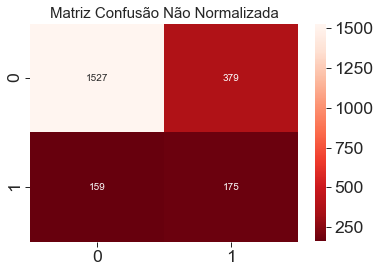

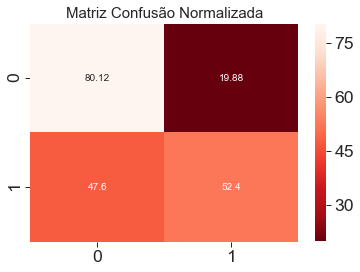

In [491]:
plot_metrics(gaussian)

In [17]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

85.76

             precision    recall  f1-score   support

          0       0.87      0.97      0.92      1906
          1       0.54      0.17      0.26       334

avg / total       0.82      0.85      0.82      2240



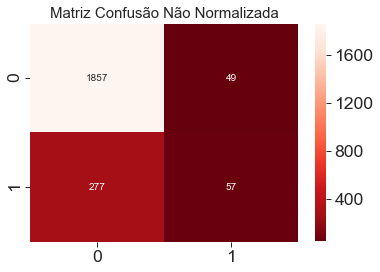

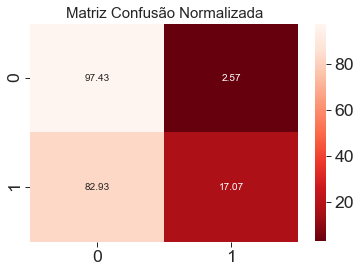

In [492]:
plot_metrics(logreg)

In [18]:
decision_tree = DecisionTreeClassifier(splitter='best',max_depth=10,
                                       min_samples_split=2,min_samples_leaf=9,
                                       random_state=44,max_leaf_nodes=None)
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

91.29

             precision    recall  f1-score   support

          0       0.90      0.92      0.91      1906
          1       0.49      0.43      0.46       334

avg / total       0.84      0.85      0.84      2240



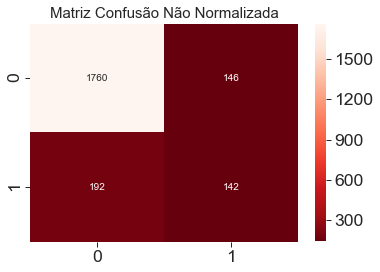

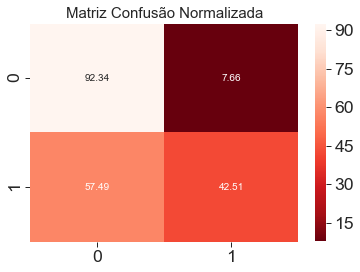

In [493]:
plot_metrics(decision_tree)

In [20]:
# Neural network

neural_network = MLPClassifier(random_state=1, max_iter=3000)
neural_network.fit(X_train, Y_train)
Y_pred = neural_network.predict(X_test),
neural_network.score(X_train, Y_train)
acc_neural_network = round(neural_network.score(X_train, Y_train) * 100, 2)
acc_neural_network

84.69

             precision    recall  f1-score   support

          0       0.88      0.45      0.59      1906
          1       0.17      0.66      0.27       334

avg / total       0.78      0.48      0.54      2240



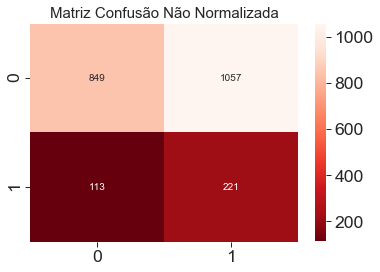

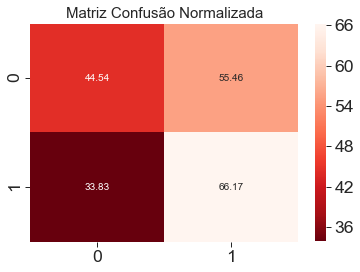

In [495]:
plot_metrics(neural_network)

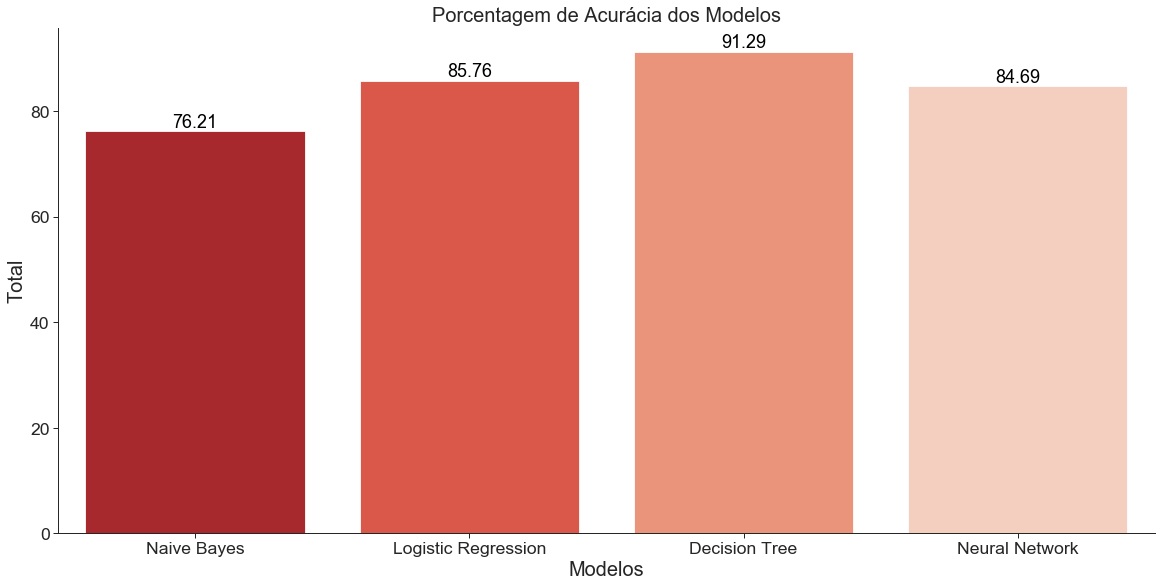

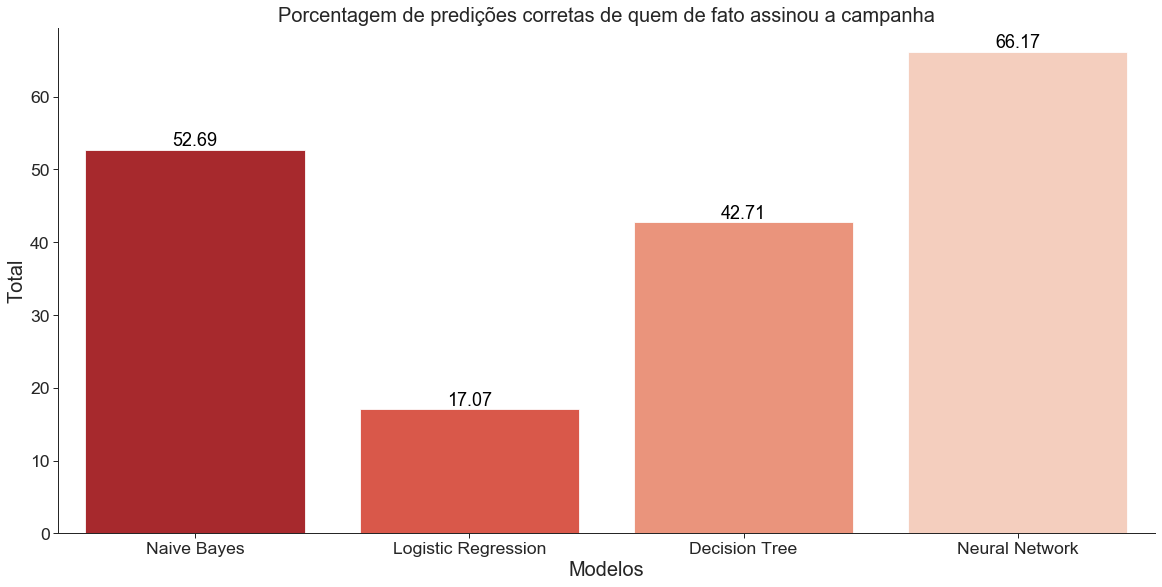

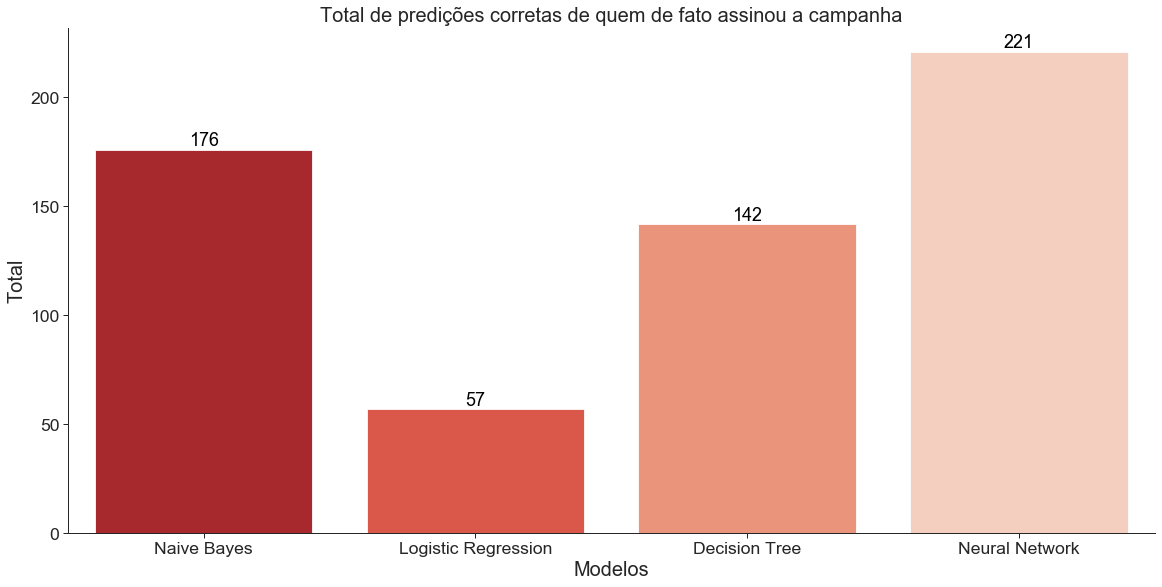

In [29]:
models = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression', 
              'Decision Tree', 'Neural Network'],
    'Score': [acc_gaussian, acc_log, acc_decision_tree, acc_neural_network],
    'Predict_percent':[52.69,17.07,42.71,66.17],
    'Predict_values':[176,57,142,221]})
models.sort_values(by='Score', ascending=False)
# models.head(10)

sns.set_context("paper", font_scale=2, rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20, "legend.title_fontsize":20}) 
sns.set_style('ticks')
sns.catplot(x='Model', y='Score', 
            #hue='state', 
            palette = "Reds_r",
            ci = None,
            data=models,
            order=['Naive Bayes', 'Logistic Regression', 
              'Decision Tree', 'Neural Network'],
            height=8.27, 
            aspect=20/10,
            kind='bar')
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
            fontsize=18, color='black', ha='center', va='bottom')
plt.xticks()
plt.xlabel('Modelos')
plt.ylabel('Total')
plt.title('Porcentagem de Acurácia dos Modelos')

sns.set_context("paper", font_scale=2, rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20, "legend.title_fontsize":20}) 
sns.set_style('ticks')
sns.catplot(x='Model', y='Predict_percent', 
            #hue='state', 
            palette = "Reds_r",
            ci = None,
            data=models,
            order=['Naive Bayes', 'Logistic Regression', 
              'Decision Tree', 'Neural Network'],
            height=8.27, 
            aspect=20/10,
            kind='bar')
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
            fontsize=18, color='black', ha='center', va='bottom')
plt.xticks()
plt.xlabel('Modelos')
plt.ylabel('Total')
plt.title('Porcentagem de predições corretas de quem de fato assinou a campanha')

sns.set_context("paper", font_scale=2, rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20, "legend.title_fontsize":20}) 
sns.set_style('ticks')
sns.catplot(x='Model', y='Predict_values', 
            #hue='state', 
            palette = "Reds_r",
            ci = None,
            data=models,
            order=['Naive Bayes', 'Logistic Regression', 
              'Decision Tree', 'Neural Network'],
            height=8.27, 
            aspect=20/10,
            kind='bar')
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=18, color='black', ha='center', va='bottom')
plt.xticks()
plt.xlabel('Modelos')
plt.ylabel('Total')
plt.title('Total de predições corretas de quem de fato assinou a campanha')
plt.show()

# Dividindo o dataset

In [496]:
def plot_metrics_split(model_split):
    
    pred_split = model_selection.cross_val_predict(model_split,X_train_split, Y_train_split)
    array = metrics.confusion_matrix(Y_train_split,pred_split)
    norm_array = array.astype('float') / array.sum(axis=1)[:, np.newaxis]
    print(metrics.classification_report(Y_train_split,pred_split))

    df_cm = pd.DataFrame(array, range(2),range(2))
    sns.heatmap(df_cm, annot=True, cmap='Reds_r',fmt='g')
    plt.title('Matriz Confusão Não Normalizada')
    plt.show()
    print('')
    df_cm = pd.DataFrame(norm_array, range(2),range(2))
    df_cm = 100*df_cm
    df_cm = df_cm.round(2)
    sns.heatmap(df_cm, annot=True, cmap='Reds_r',fmt='g')
    plt.title('Matriz Confusão Normalizada')
    plt.show()

In [23]:
features = ['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue',
       'Time_as_customer', 'Accepted', 'Age', 'MntTotal', 'Age_bins',
       'Income_bins', 'income_bins', 'Recency_bins', 'MntWines_bins',
       'MntFruits_bins', 'MntMeatProducts_bins', 'MntFishProducts_bins',
       'MntSweetProducts_bins', 'MntGoldProds_bins', 'NumDealsPurchases_bins',
       'NumWebPurchases_bins', 'NumCatalogPurchases_bins',
       'NumStorePurchases_bins', 'NumWebVisitsMonth_bins', 'MntTotal_bins',
       'Have_Children']
target = ['Response']

X = df[features]
Y = df[target]

split_test_size = 0.15

treino_x, teste_x, treino_y, test_y= train_test_split(X, Y, test_size = split_test_size, random_state = 42)

x_df = treino_x[features]
x_dummy = pd.get_dummies(x_df)
x_dummy = x_dummy.reindex(labels=x_df.columns,axis=1)
X_train_split = x_dummy.values
X_train_split = np.nan_to_num(X_train_split)

Y_train_split = treino_y[target].values


x1_df = teste_x[features]
x1_dummies_df = pd.get_dummies(x1_df)
x1_dummies_df = x1_dummies_df.reindex(labels=x1_df.columns,axis=1)
X_test_split = x1_dummies_df.values
X_test_split = np.nan_to_num(X_test_split)

test_y_split = test_y[target].values


In [24]:
# Gaussian Naive Bayes

gaussian_split = GaussianNB()
gaussian_split.fit(X_train_split, Y_train_split)
Y_pred_split = gaussian_split.predict(X_test_split)
acc_gaussian_split = round(gaussian_split.score(X_train_split, Y_train_split) * 100, 2)
acc_gaussian_split

75.95

             precision    recall  f1-score   support

          0       0.91      0.80      0.85      1626
          1       0.31      0.53      0.39       278

avg / total       0.82      0.76      0.78      1904



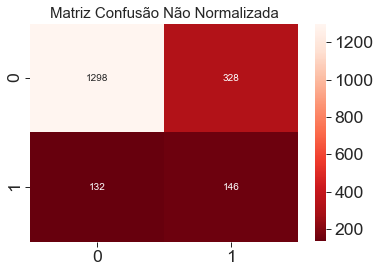

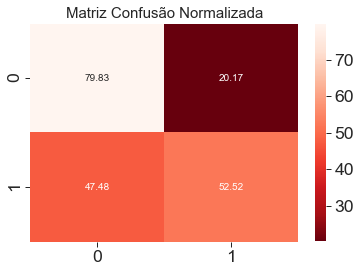

In [498]:
plot_metrics_split(gaussian_split)

In [25]:
logreg_split = LogisticRegression()
logreg_split.fit(X_train_split, Y_train_split)
Y_pred_split = logreg_split.predict(X_test_split)
acc_log_split = round(logreg_split.score(X_train_split, Y_train_split) * 100, 2)
acc_log_split

86.03

             precision    recall  f1-score   support

          0       0.87      0.97      0.92      1626
          1       0.51      0.18      0.27       278

avg / total       0.82      0.86      0.82      1904



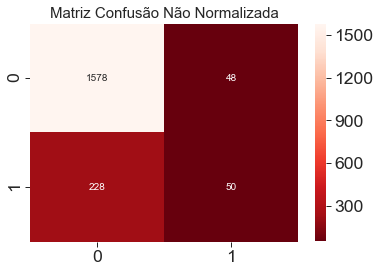

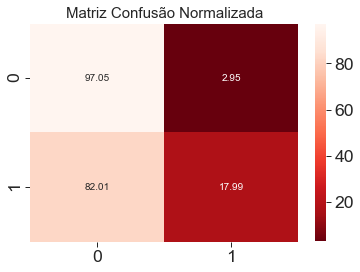

In [508]:
plot_metrics_split(logreg_split)

In [26]:
# Decision Tree
decision_tree_split = DecisionTreeClassifier(splitter='best',max_depth=10,
                                       min_samples_split=2,min_samples_leaf=9,
                                       min_weight_fraction_leaf = 0, 
                                       random_state=44,max_leaf_nodes=None)
decision_tree_split.fit(X_train_split, Y_train_split)
Y_pred_split = decision_tree_split.predict(X_test_split)
acc_decision_tree_split = round(decision_tree_split.score(X_train_split, Y_train_split) * 100, 2)
acc_decision_tree_split

91.49

             precision    recall  f1-score   support

          0       0.90      0.92      0.91      1626
          1       0.49      0.43      0.46       278

avg / total       0.84      0.85      0.85      1904



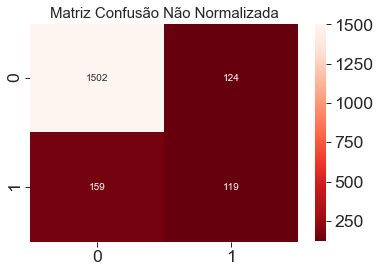

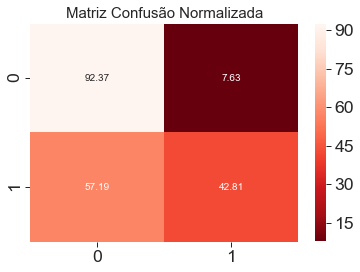

In [500]:
plot_metrics_split(decision_tree_split)

In [27]:
# Neural network

neural_network_split = MLPClassifier(random_state=40, max_iter=3000)
neural_network_split.fit(X_train_split, Y_train_split)
Y_pred_split = neural_network_split.predict(X_test_split),
neural_network_split.score(X_train_split, Y_train_split)
acc_neural_network_split = round(neural_network_split.score(X_train_split, Y_train_split) * 100, 2)
acc_neural_network_split

85.24

             precision    recall  f1-score   support

          0       0.88      0.54      0.66      1626
          1       0.17      0.56      0.26       278

avg / total       0.77      0.54      0.61      1904



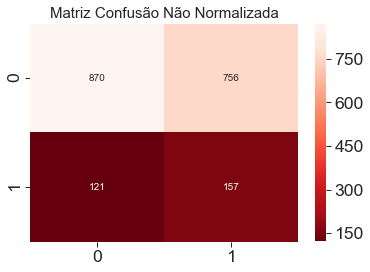

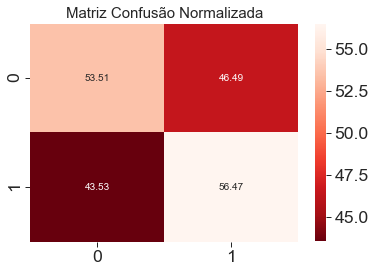

In [502]:
plot_metrics_split(neural_network_split)

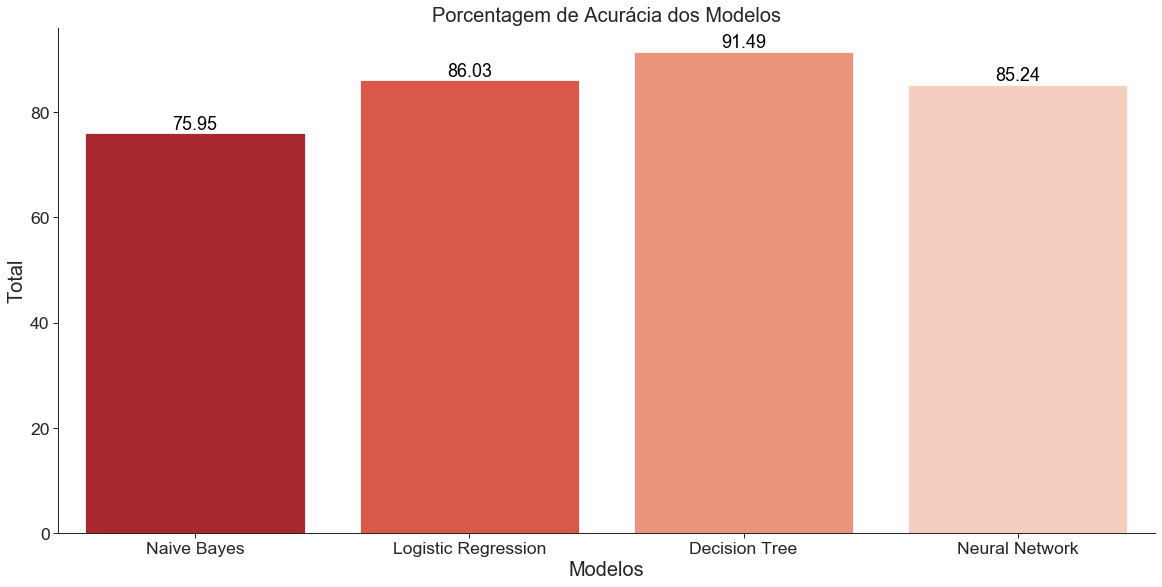

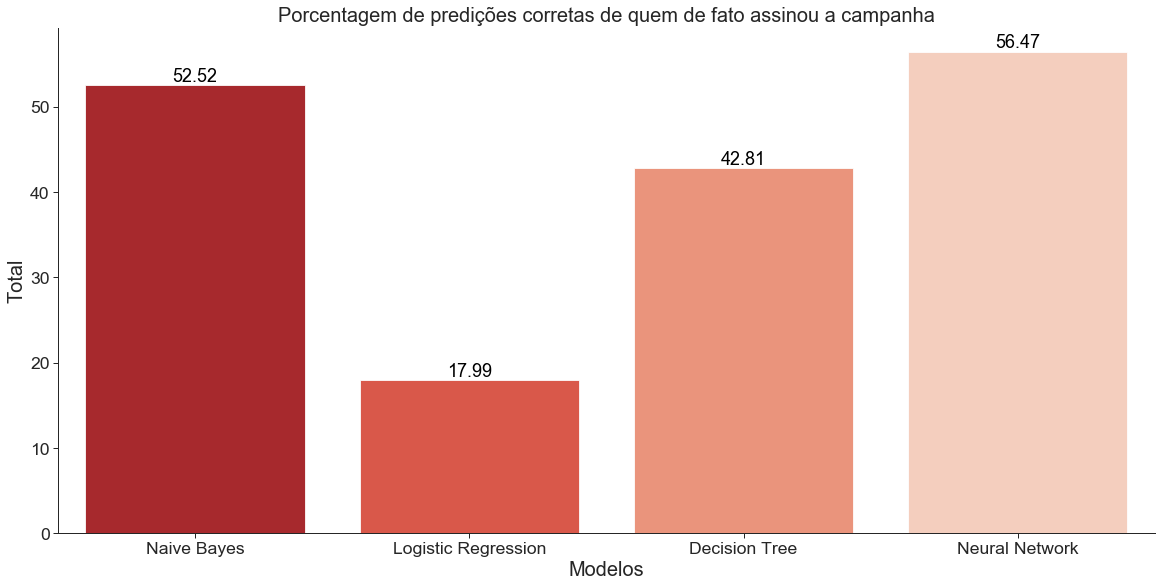

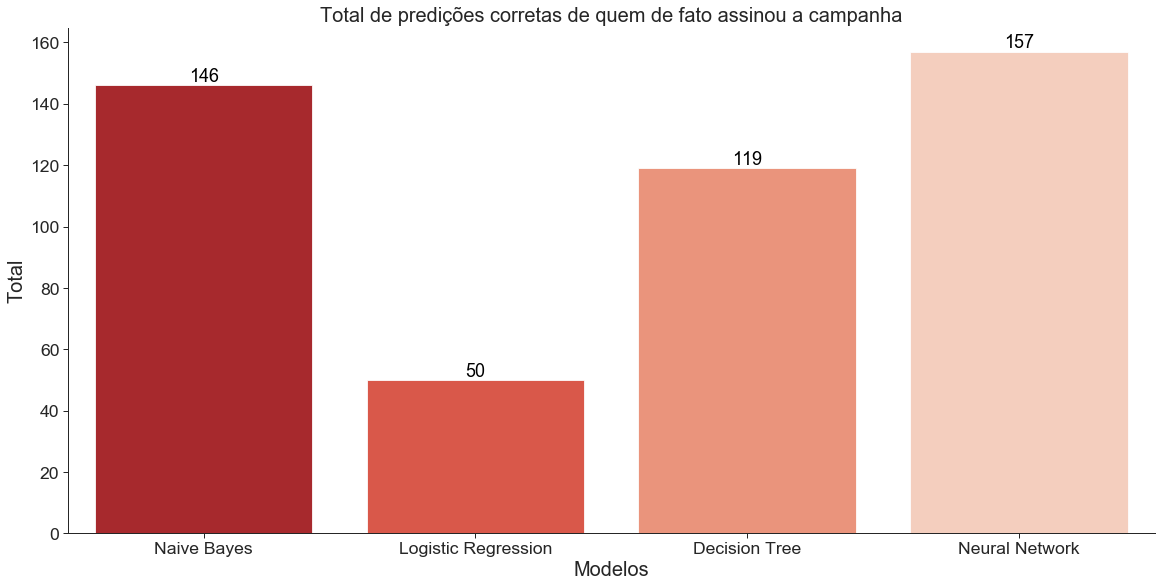

In [33]:
models = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression', 
              'Decision Tree', 'Neural Network'],
    'Score': [acc_gaussian_split, acc_log_split, acc_decision_tree_split, acc_neural_network_split],
    'Predict_percent':[52.52,17.99,42.81,56.47],
    'Predict_values':[146,50,119,157]})
models.sort_values(by='Score', ascending=False)
# models.head(10)
sns.set_context("paper", font_scale=2, rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20, "legend.title_fontsize":20}) 
sns.set_style('ticks')
sns.catplot(x='Model', y='Score', 
            #hue='state', 
            palette = "Reds_r",
            ci = None,
            data=models,
            order=['Naive Bayes', 'Logistic Regression', 
              'Decision Tree', 'Neural Network'],
            height=8.27, 
            aspect=20/10,
            kind='bar')
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
            fontsize=18, color='black', ha='center', va='bottom')
plt.xticks()
plt.xlabel('Modelos')
plt.ylabel('Total')
plt.title('Porcentagem de Acurácia dos Modelos')

sns.set_context("paper", font_scale=2, rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20, "legend.title_fontsize":20})
sns.set_style('ticks')
sns.catplot(x='Model', y='Predict_percent', 
            #hue='state', 
            palette = "Reds_r",
            ci = None,
            data=models,
            order=['Naive Bayes', 'Logistic Regression', 
              'Decision Tree', 'Neural Network'],
            height=8.27, 
            aspect=20/10,
            kind='bar')
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
            fontsize=18, color='black', ha='center', va='bottom')
plt.xticks()
plt.xlabel('Modelos')
plt.ylabel('Total')
plt.title('Porcentagem de predições corretas de quem de fato assinou a campanha')

sns.set_context("paper", font_scale=2, rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20, "legend.title_fontsize":20})
sns.set_style('ticks')
sns.catplot(x='Model', y='Predict_values', 
            #hue='state', 
            palette = "Reds_r",
            ci = None,
            data=models,
            order=['Naive Bayes', 'Logistic Regression', 
              'Decision Tree', 'Neural Network'],
            height=8.27, 
            aspect=20/10,
            kind='bar')
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=18, color='black', ha='center', va='bottom')
plt.xticks()
plt.xlabel('Modelos')
plt.ylabel('Total')
plt.title('Total de predições corretas de quem de fato assinou a campanha')
plt.show()

Muito obrigado pela oportunidade!